In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scvi
import math
from glob import glob
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

Global seed set to 0


In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.2 numpy==1.21.6 scipy==1.9.0 pandas==1.4.3 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


In [3]:
adata = sc.read_h5ad("/project2/gilad/rjangi1/ebQTL/trajectories/cardiomyocytes/data/anndata_objects/fdr01_2nd_cmstages.h5ad")

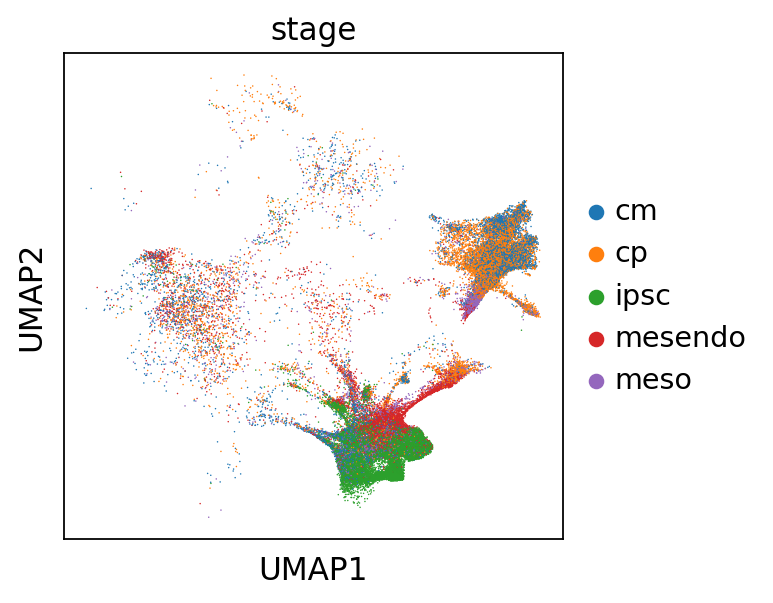

In [6]:
sc.pl.umap(adata, color=["stage"])

In [7]:
ipsc = adata[adata.obs['stage']=='ipsc']

## Sample Summary

How many cells we have for each individual in each cell type?

In [8]:
cell_counts = ipsc.obs[['donor_id_x']]
cell_counts = pd.DataFrame(cell_counts.value_counts()).reset_index(inplace=False).rename(columns={0: "n_cells"})
cell_counts

,donor_id_x,n_cells
0,NA18907,5841
1,NA19153,5115
2,NA19144,4183
3,NA18511,1805
4,NA19210,1573
5,NA18913,1407
6,NA19127,1356
7,NA18486,909
8,NA18862,868
9,NA19160,859


To get this into proper form, we need to:
- Reformat cell types
- Add a column of nUMIs per sample (we don't need these for this analysis so we'll leave it as NaN for now)

In [9]:
cell_counts['type'] = "IPSC"
cell_counts['individual'] = [s.replace("NA", "") for s in cell_counts['donor_id_x']]
cell_counts['n_umi'] = np.nan
cell_counts['ind_type'] = cell_counts['individual'].astype(str) + "_" + cell_counts['type'].astype(str)
cell_counts = cell_counts[['ind_type', 'n_umi', 'individual', 'type', 'n_cells']]
cell_counts

,ind_type,n_umi,individual,type,n_cells
0,18907_IPSC,NaN,18907,IPSC,5841
1,19153_IPSC,NaN,19153,IPSC,5115
2,19144_IPSC,NaN,19144,IPSC,4183
3,18511_IPSC,NaN,18511,IPSC,1805
4,19210_IPSC,NaN,19210,IPSC,1573
5,18913_IPSC,NaN,18913,IPSC,1407
6,19127_IPSC,NaN,19127,IPSC,1356
7,18486_IPSC,NaN,18486,IPSC,909
8,18862_IPSC,NaN,18862,IPSC,868
9,19160_IPSC,NaN,19160,IPSC,859


We'll drop any samples with less than 5 cells

In [10]:
cell_counts['dropped'] = cell_counts['n_cells'] < 5

In [12]:
cell_counts.to_csv("/project2/gilad/jpopp/ebQTL/data/static/radhika_ipsc/pseudobulk-scran/sample_summary.tsv",
                  sep="\t", index=False)

## Cell Type Summary

We will filter to samples with at least 5 cells, and cell types with over 25 individuals represented.

In [13]:
ind_counts = cell_counts[cell_counts['n_cells'] >= 5]
ind_counts = pd.DataFrame(ind_counts[['type']].value_counts()).reset_index(inplace=False).rename(columns={0: "n"})
ind_counts = ind_counts[ind_counts['n']>25]
ind_counts

,type,n
0,IPSC,41


In [14]:
ind_counts.to_csv("/project2/gilad/jpopp/ebQTL/data/static/radhika_ipsc/pseudobulk-scran/samples_per_celltype.tsv",
                  sep="\t", index=False)

## Pseudobulk Aggregation

First, we can highlight which samples will be kept for QTL analysis

In [15]:
cell_types_inc = ind_counts['type']

In [16]:
samples_inc = cell_counts[(cell_counts['dropped'] == False) & (cell_counts['type'].isin(cell_types_inc))]['ind_type']
samples_inc

0     18907_IPSC
1     19153_IPSC
2     19144_IPSC
3     18511_IPSC
4     19210_IPSC
5     18913_IPSC
6     19127_IPSC
7     18486_IPSC
8     18862_IPSC
9     19160_IPSC
10    19193_IPSC
11    18855_IPSC
12    19102_IPSC
13    19159_IPSC
14    18856_IPSC
15    18912_IPSC
16    18507_IPSC
17    19207_IPSC
18    19093_IPSC
19    18517_IPSC
20    19143_IPSC
21    19204_IPSC
22    18519_IPSC
23    19140_IPSC
24    19225_IPSC
25    18502_IPSC
26    18498_IPSC
27    18501_IPSC
28    18489_IPSC
29    18516_IPSC
30    19116_IPSC
31    18508_IPSC
32    18505_IPSC
33    19257_IPSC
34    19152_IPSC
35    19114_IPSC
36    18522_IPSC
37    19101_IPSC
38    19203_IPSC
39    18499_IPSC
40    19099_IPSC
Name: ind_type, dtype: object

In [17]:
cell_subset = ipsc.obs[['donor_id_x']]
cell_subset['type'] = "IPSC"
cell_subset['ind'] = [s.replace("NA", "") for s in cell_subset['donor_id_x'].astype(str)]
cell_subset['sample'] = cell_subset['ind'] + "_" + cell_subset['type']
cell_subset = cell_subset[cell_subset['sample'].isin(samples_inc)]
cell_subset

/tmp/jobs/22940653/ipykernel_59934/3416183574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset['type'] = "IPSC"
/tmp/jobs/22940653/ipykernel_59934/3416183574.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset['ind'] = [s.replace("NA", "") for s in cell_subset['donor_id_x'].astype(str)]
/tmp/jobs/22940653/ipykernel_59934/3416183574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

,donor_id_x,type,ind,sample
cell,,,,
TGTTCATAGCGTCTCG-21,NA18907,IPSC,18907,18907_IPSC
GCAACATCAGAAGCGT-31,NA19153,IPSC,19153,19153_IPSC
TTATTGCCACTACGGC-17,NA19210,IPSC,19210,19210_IPSC
AATGACCAGCGAACTG-73,NA19127,IPSC,19127,19127_IPSC
TTCCAATGTGCGGTAA-16,NA19210,IPSC,19210,19210_IPSC
...,...,...,...,...
GTGAGTTCAAGCGCAA-14,NA18517,IPSC,18517,18517_IPSC
AGTAACCGTTCCCACT-5,NA18517,IPSC,18517,18517_IPSC
TAAGCACCATAGATCC-40,NA18862,IPSC,18862,18862_IPSC


For pseudobulk aggregation, we're going to use the scran-normalized data

In [18]:
scran_adata = sc.read_h5ad("/project2/gilad/ktayeb/ebqtl-workflowr/output/proc/EB_high_pass_filtered_normalized.h5ad")

In [19]:
scran_adata = scran_adata[cell_subset.index]

In [20]:
scran_adata

View of AnnData object with n_obs × n_vars = 28611 × 35324
    obs: 'sample_id', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'donor_id', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True', 'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Formation.replicate', 'collection.replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'collection.group.label', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.', 'leiden_coarse', 'sizeFactor', 'scranGroup', 'scranCluster'
    var: 'gene_ids', 'feature_types'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: '

To compute the mean, we're first going to get a one-hot encoding of the sample assignment for each cell

In [21]:
onehot = OneHotEncoder(sparse=True).fit_transform(cell_subset[['sample']])
onehot

<28611x41 sparse matrix of type '<class 'numpy.float64'>'
	with 28611 stored elements in Compressed Sparse Row format>

In [22]:
n_cells = onehot.sum(axis=0)

In [23]:
pseudobulk_sum = scran_adata.X.transpose() * onehot

In [24]:
pseudobulk_mean = pseudobulk_sum / n_cells

In [25]:
pseudobulk_mean = pd.DataFrame(pseudobulk_mean, 
             index=scran_adata.var_names, columns=cell_subset['sample'].astype("category").cat.categories)

In [26]:
pseudobulk_mean.to_csv("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/radhika_ipsc.pseudobulk-scran.tsv",
                  sep="\t", index_label="gene")

### Check that pseudobulk aggregation is correct

In [24]:
pseudobulk_mean

,18486_IPSC,18489_IPSC,18498_IPSC,18499_IPSC,18501_IPSC,18502_IPSC,18505_IPSC,18507_IPSC,18508_IPSC,18511_IPSC,...,19160_IPSC,19190_IPSC,19193_IPSC,19203_IPSC,19204_IPSC,19207_IPSC,19209_IPSC,19210_IPSC,19225_IPSC,19257_IPSC
MIR1302-2HG,0.001300,0.000000,0.000000,0.000000,0.000000,0.001248,0.000000,0.000657,0.000000,0.000279,...,0.001048,0.000000,0.000899,0.000000,0.000000,0.001010,0.000000,0.000681,0.000000,0.000000
OR4F5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AL627309.1,0.019576,0.039364,0.016023,0.009337,0.049839,0.041136,0.041101,0.008208,0.024191,0.017316,...,0.014429,0.000000,0.026746,0.000000,0.046116,0.030929,0.000000,0.011660,0.030350,0.016062
AL627309.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AL627309.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000188,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC136616.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC023491.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000490,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC007325.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AC007325.4,0.054912,0.125579,0.109919,0.188230,0.134689,0.128984,0.048035,0.055478,0.053845,0.029071,...,0.031261,0.052663,0.099843,0.016772,0.077761,0.097717,0.203016,0.079460,0.065655,0.110023


In [25]:
test_cells = cell_subset[cell_subset['sample']=="18486_IPSC"]
test = scran_adata[test_cells.index]
test

View of AnnData object with n_obs × n_vars = 2235 × 35324
    obs: 'sample_id', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'donor_id', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True', 'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Formation.replicate', 'collection.replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'collection.group.label', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.', 'leiden_coarse', 'sizeFactor', 'scranGroup', 'scranCluster'
    var: 'gene_ids', 'feature_types'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X

In [26]:
list(test.var_names).index("AL627309.1")

2

In [27]:
np.mean(test.X[:,2])

0.019576179

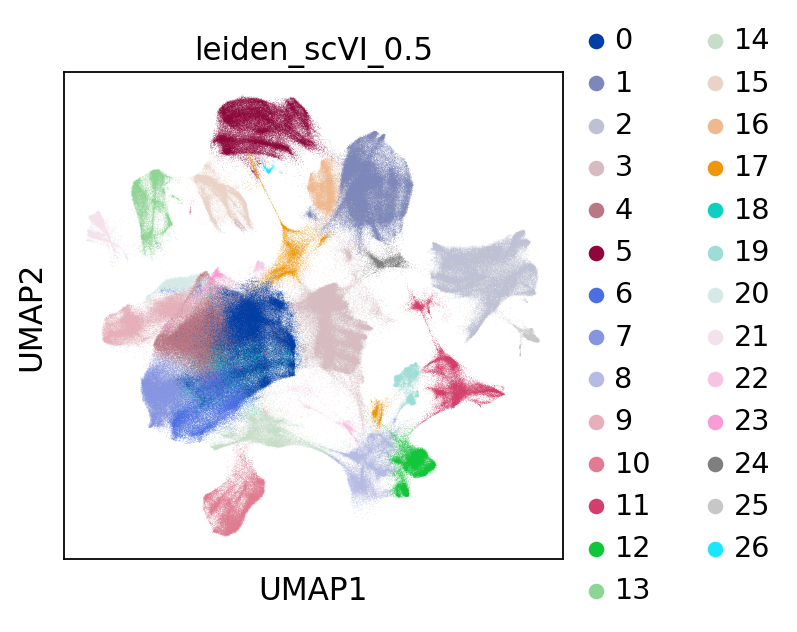

In [28]:
sc.pl.umap(adata, color=["leiden_scVI_0.5"])